# GPU 설정

In [5]:
## GPU 사용시, GPU를 먼저 선택 후, 아래 코드(구글 드라이브 마운팅) 실행해야함!!!
# # 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')
# 코드 실행

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


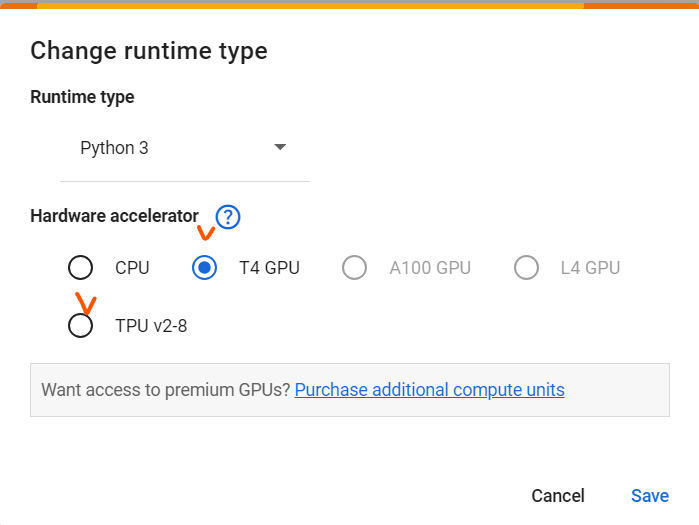

In [ ]:
import torch
## Google Colab에서 GPU 사용 설정, gpu가 있으면 gpu 사용, 아니면 cpu  사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# import torch

## 사용 가능한 GPU가 몇 개인지 확인
gpu_count = torch.cuda.device_count()

## 각 GPU에 대한 정보 출력
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")
    print(f"총 멀티프로세서 수: {torch.cuda.get_device_capability(i)}")  # Compute Capability 확인
    print("멀티프로세서 =/= 코어수 ")

GPU 0: Tesla T4
총 멀티프로세서 수: (7, 5)
멀티프로세서 =/= 코어수 


In [ ]:
# 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call([sys.executable, "!", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
install_and_import(['torchviz'])


torchviz is already installed.


In [6]:
ppath = '/content/drive/MyDrive/aibootcamp/딥러닝/data'

In [7]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 데이터 읽기

In [11]:
stock_data = pd.read_csv(ppath + '/stock_data_M8.csv', index_col = 0, parse_dates = True)
stock_data

,AAPL,AMZN,GOOGL,MSFT,NFLX,NVDA,TSLA,META
Date,,,,,,,,
2015-01-02 00:00:00+00:00,24.373959,15.426000,26.412100,40.232853,49.848572,0.483177,14.620667,78.214508
2015-01-05 00:00:00+00:00,23.687302,15.109500,25.908844,39.862869,47.311428,0.475016,14.006000,76.958290
2015-01-06 00:00:00+00:00,23.689537,14.764500,25.269430,39.277802,46.501431,0.460614,14.085333,75.921410
2015-01-07 00:00:00+00:00,24.021709,14.921000,25.195112,39.776844,46.742859,0.459414,14.063333,75.921410
2015-01-08 00:00:00+00:00,24.944685,15.023000,25.282898,40.946987,47.779999,0.476696,14.041333,77.945320
...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.868134,153.419998,141.140518,372.543915,486.760010,48.819527,252.539993,352.329193
2023-12-26 00:00:00+00:00,192.320221,153.410004,141.170441,372.623505,491.190002,49.268425,256.609985,353.764862
2023-12-27 00:00:00+00:00,192.419830,153.339996,140.023270,372.036713,491.790009,49.406395,261.440002,356.755829


### 데이터 확인

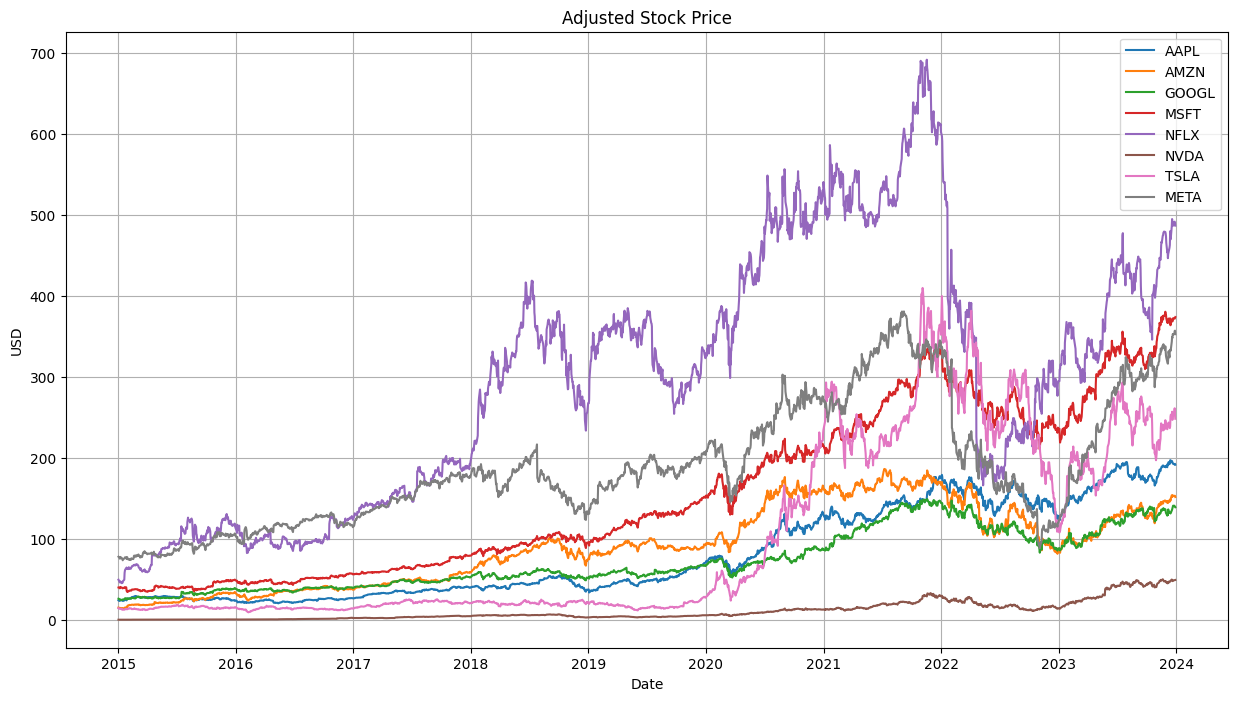

In [12]:
## 데이터 시각화
plt.figure(figsize = (15, 8))
for ticker in stock_data.columns:
    plt.plot(stock_data.index, stock_data[ticker], label = ticker)

plt.title("Adjusted Stock Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

### 전처리

In [13]:
data = stock_data

In [14]:
## AAPL 추출
aapl_stock = data['AAPL'].values.reshape(-1, 1)
aapl_stock

array([[ 24.37395859],
       [ 23.68730164],
       [ 23.68953705],
       ...,
       [192.41983032],
       [192.84822083],
       [191.80218506]])

In [15]:
from sklearn.preprocessing import MinMaxScaler

## MinMaxScaler를 사용하여 0-1 범위로 스케일링
normalizer = MinMaxScaler(feature_range=(0, 1))

aapl_stock_normalized = normalizer.fit_transform(aapl_stock)

In [16]:
##  2주일(14일)의 데이터로 학습하고 3일 예측
sequence_length = 14
prediction_length = 3

# 입력과 타겟 시퀀스 생성
def create_sequences(data, sequence_length, prediction_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - prediction_length):
        sequences.append(data[i: (i+sequence_length)])
        targets.append(data[(i+sequence_length):  (i + sequence_length + prediction_length) ])
    return np.array(sequences), np.array(targets)

In [17]:
## 학습-테스트 기간 정의
# 데이터를 2주일(14일)의 데이터로 학습하고 3일 예측
sequence_length = 14
prediction_length = 3

# 입력과 타겟 시퀀스 생성
X_aapl, y_aapl = create_sequences(aapl_stock_normalized, sequence_length, prediction_length)

X_aapl.shape, y_aapl.shape  # (샘플 수, 시퀀스 길이, 변수 수)

((2247, 14, 1), (2247, 3, 1))

# LSTM

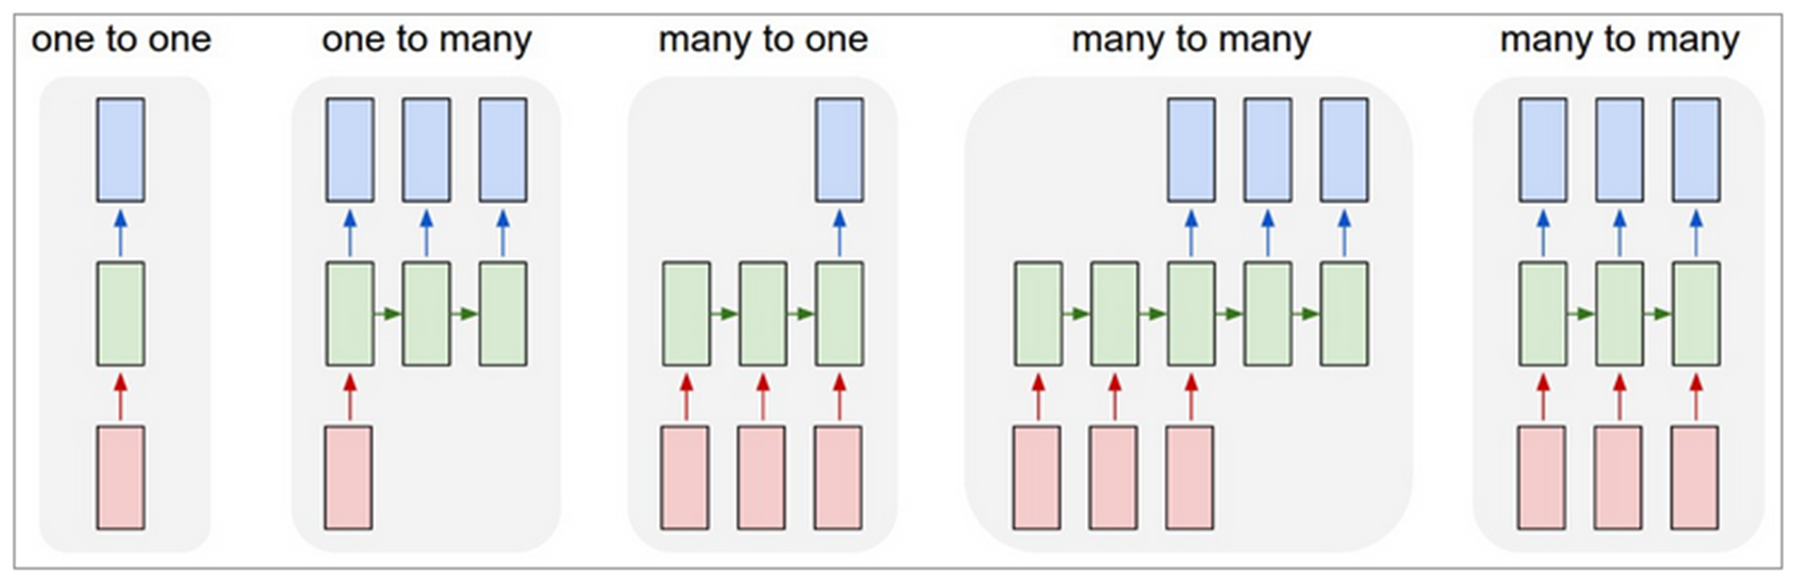

- ManytoMany
   - ManytoMany는 입력과 출력이 모두 시퀀스 일때 활용가능한 방식
   - 기계 번역 등에 사용(영어 문장을 받아 프랑스어 문장으로 번역하는 일)
   - 입력도 여러 요소,  출력도 여러 요소
   
- **일반 LSTM 구조**
  -  주로 시계열 예측, 감성 분석 등 하나의 입력에 대해 하나의 출력을 예측하는 경우
  - 주로 단순한 예측에 사용

- Seq2seq
  - ManytoMany 문제를 해결하기 위한 특정 모델 구조
  -  **인코더(encoder)**와 **디코더(decoder)**로 구성
  - 인코더는 입력 시퀀스를 처리하고, 이를 하나의 고정된 벡터로 압축
  - 디코더는 이 벡터를 기반으로 출력 시퀀스를 생성
  - 기계 번역, 텍스트 요약과 같은 작업에서 Seq2Seq 모델 많이 사용
  - 다소 복잡한 구조


## 파이토치

In [18]:
## 재현을 위한 랜덤 시드 고정...
import random
import numpy as np
import torch

## 랜덤 시드 고정 함수 정의
def set_seed(seed):
  ## 시드 고정
  random.seed(seed)                 # Python 기본 랜덤 시드 고정
  np.random.seed(seed)           # NumPy 랜덤 시드 고정
  torch.manual_seed(seed)     # PyTorch CPU 시드 고정

  ## GPU가 있는 경우 시드 고정, GPU 연산에서 사용되는 난수 생성기의 시드를 고정
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 시드 고정

  ## CuDNN 설정 (GPU 사용 시), CuDNN 라이브러리의 비결정적 연산을 방지,  동일한 결과를 얻기 위한 설정..
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


## 시드 고정
set_seed(123)  # 원하는 시드 값 설정


### 파이토치 데이터 형식으로 변환
- df, np.array to Tensor 형태

In [19]:
## 파이토치 텐서로 변환
X_aapl_tensor = torch.tensor(X_aapl, dtype = torch.float32)
y_aapl_tensor = torch.tensor(y_aapl, dtype = torch.float32)

In [20]:
X_aapl_tensor.shape, y_aapl_tensor.shape

(torch.Size([2247, 14, 1]), torch.Size([2247, 3, 1]))

### 모델 정의

In [21]:
# 입력 데이터 (데이터 시퀀스) -> LSTM 레이어 (2개 층) -> Fully Connected 레이어 -> 출력

In [22]:
# import torch
# import torch.nn as nn

## LSTM 모델
class StockLSTM(nn.Module):
    def __init__(self,
                              input_size,                   # 입력 특징의 크기 (특성의 개수, 예: 주가 데이터의 변수 수)
                              hidden_size,                #  LSTM의 hidden state 크기 (LSTM의 메모리 용량)
                              output_size = 1,          # 출력 크기, 기본값은 1 (각 타임스텝에서 1개의 주가 예측)
                              num_layers = 2,          # LSTM 레이어의 개수 (기본적으로 2개의 LSTM 레이어 사용)
                              dropout_prob = 0.2):


        super(StockLSTM, self).__init__() # 모델 초기화
        self.hidden_size = hidden_size       # LSTM의 hidden state 크기 설정
        self.num_layers = num_layers        # LSTM 레이어 개수 설정

        ## LSTM Layer
        self.lstm = nn.LSTM(input_size,
                                                hidden_size,
                                                num_layers,
                                                batch_first = True,            # 입력의 첫 번째 차원이 배치 크기임을 지정
                                                dropout = dropout_prob)
        # 입력: (배치 크기, 시퀀스 길이, input_size)
        # 출력: (배치 크기, 시퀀스 길이, hidden_size)

        ## Fully connected layer (각 타임스텝에서 1개의 주가 예측)
        self.fc = nn.Linear(hidden_size,  output_size)
        # 출력: (배치 크기, 시퀀스 길이, output_size)


    def forward(self, x):

        ## LSTM에 사용할 초기 hidden state와 cell state 생성
        hidden_state = torch.zeros(self.num_layers,    x.size(0),    self.hidden_size).to(x.device)  # (num_layers, 배치 크기, hidden_size)
        cell_state = torch.zeros(self.num_layers,     x.size(0),     self.hidden_size).to(x.device)        # (num_layers, 배치 크기,  hidden_size)

        ## LSTM의 Forward pass (전체 타임스텝에 대한 출력)
        out, _ = self.lstm(x, (hidden_state, cell_state))              # LSTM의 출력: (배치 크기, 시퀀스 길이, hidden_size)

        ## 모든 타임스텝의 출력을 Fully Connected Layer에 전달
        out = self.fc(out)                                                                         # FC 레이어를 거친 후 출력: (배치 크기, 시퀀스 길이, output_size)

        ## 마지막 3개의 타임스텝의 출력을 반환 (3일간의 예측)
        output = out[:, -3:, :]  # (배치 크기, 3일 예측, 1개의 주가)

        return output


### 모델 초기화

In [23]:
# input - lstm layer 1 - lstm layer 2 - fc - output

In [24]:
## 하이퍼파라미터 설정
input_size = 1       # 주가 하나의 값(변수는 apple 주가 하나, 변수차원이 1이기 때문에 input_size = 1)
hidden_size = 50
output_size = 1     # 각 타임스텝에서 예측할 주가 값 1개(변수가 1개)
num_layers = 2
dropout_prob = 0.2
# num_epochs = 100
# learning_rate = 0.001
# batch_size = 32

## 모델 초기화
model = StockLSTM(input_size,
                                          hidden_size,
                                          output_size,
                                          num_layers,
                                          dropout_prob).to(device)
model

StockLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

### 모델 구조 확인

In [25]:
## 샘플 입력 데이터
batch_size = 16
sequence_length = 14

x = torch.randn(batch_size, sequence_length, input_size).to(device)
output = model(x)

print(f"입력 형태: {x.shape}")
print(f"출력 형태: {output.shape}")


입력 형태: torch.Size([16, 14, 1])
출력 형태: torch.Size([16, 3, 1])


In [26]:
!pip install torchinfo

## 모델 구조 출력
from torchinfo import summary
summary(model, input_size = (batch_size,  sequence_length,  input_size), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
StockLSTM                                [16, 3, 1]                --
├─LSTM: 1-1                              [16, 14, 50]              31,000
├─Linear: 1-2                            [16, 14, 1]               51
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.94
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.12
Estimated Total Size (MB): 0.22

In [27]:
# 현재 모델 저장후, https://netron.app/ 접속하여, accept, upload 후 확인

## 현재 모델 저장
# torch.save(model,  ppath + "/lstm_model.pth") 애러 발생시 아래 실행
torch.save(model.state_dict(),  ppath + "/lstm_model.pth")

### 트레이닝 함수 정의

In [28]:
from torch.utils.data import DataLoader

## 학습 함수 정의
def train_model(model: nn.Module,
                                  train_loader: DataLoader,
                                  criterion: nn.Module,
                                  optimizer: optim.Optimizer,
                                  num_epochs: int):

    model.train()  # 학습 모드로 전환
    epoch_losses = []  # 에폭별 손실 저장 리스트
    running_loss = 0.0  # 에폭 동안의 누적 손실 초기화

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # print(X_batch.shape, y_batch.shape)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

       # 에폭 종료 후 평균 손실 계산 및 저장
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    return epoch_losses, model


### 가중치 초기화

In [29]:
import torch.nn.init as init

## He 초기화 함수 정의
# relu 계열, 딥러닝에 더 적합
def initialize_weights_he(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity = 'relu')  # He 초기화 (uniform 분포)
        if m.bias is not None:
            init.zeros_(m.bias)                                                                       # 편향은 0으로 초기화

## 순서는 모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화 !!!!!
model.apply(initialize_weights_he)  # 가중치 초기화

StockLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

### 손실 함수와 옵티마이저 정의


In [30]:
## 손실 함수
criterion = nn.MSELoss()

## 옵티마이저
## adam > = Nadam(adam의 약간 개선 버전) == adadelta(메모리 문제있으면)
optimizer = optim.Adam(
        model.parameters(),      # 모델의 학습 가능한 파라미터 전달
        lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
        weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
        amsgrad = False               # AMSGrad 알고리즘(adam 개선 버전..)을 사용할지 여부, 기본값은 False
)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### 데이터 로더
- 데이터를 미니 배치 단위로 나누어 모델에 공급(feed) 하는 방법
- 셔플, 병렬 처리 등을 지원하며, 학습 속도를 최적화할때 필요
- 배치크기 정하기..
  - 보통 2의 승수로 선택 64, 128, 1024 등
  - 왕도가 없음..

In [31]:
## X_aapl_tensor 를 "순서대로" 70:30 으로 분할, 시계열 데이터임에 유의

train_size = int(len(X_aapl_tensor) * 0.7)
test_size = len(X_aapl_tensor) - train_size

X_aapl_train = X_aapl_tensor[:train_size]
y_aapl_train = y_aapl_tensor[:train_size]

X_aapl_test = X_aapl_tensor[train_size:]
y_aapl_test = y_aapl_tensor[train_size:]

print("X_aapl_train shape:", X_aapl_train.shape)
print("y_aapl_train shape:", y_aapl_train.shape)
print("X_aapl_test shape:", X_aapl_test.shape)
print("y_aapl_test shape:", y_aapl_test.shape)


X_aapl_train shape: torch.Size([1572, 14, 1])
y_aapl_train shape: torch.Size([1572, 3, 1])
X_aapl_test shape: torch.Size([675, 14, 1])
y_aapl_test shape: torch.Size([675, 3, 1])


In [32]:
from torch.utils.data import DataLoader, TensorDataset

## TensorDataset 생성
train_dataset = TensorDataset(X_aapl_train, y_aapl_train)
test_dataset = TensorDataset(X_aapl_test, y_aapl_test)

In [33]:
## 데이터로더 생성
# train data

train_loader = torch.utils.data.DataLoader(train_dataset,
                                                                                         batch_size = 64,
                                                                                         shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                                                                        batch_size = 64,
                                                                                        shuffle = False)


In [34]:
## 첫 번째 배치의 데이터 확인
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break


torch.Size([64, 14, 1]) torch.Size([64, 3, 1])


In [35]:
## CPU 코어 개수 출력
cpu_cores = os.cpu_count()
cpu_cores

2

### 모델 학습
- 중요 순서는 __모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화__

In [36]:
## 모델 학습...
num_epochs = 60

## 재학습시에는 모델 + 옵티마이져 초기화 를 꼭 해줘야 함!!!!
# # 모델 초기화
# model = StockLSTM(input_size,
#                   hidden_size,
#                   output_size,
#                   num_layers,
#                   dropout_prob).to(device)
# optimizer = optim.Adam(
#         model.parameters(),      # 모델의 학습 가능한 파라미터 전달
#         lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
#         weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
#         amsgrad = False               # AMSGrad 알고리즘을 사용할지 여부, 기본값은 False
# )
## 그렇지 않으면 이전 학습에서 이미 학습한 가중치를 기반으로 계속 업데이트하게됨...이상한 결과가 나올 수 있다..

set_seed(123)

loss_history, trained_model = train_model(model = model,
                                                                                          train_loader = train_loader,
                                                                                          criterion = criterion,
                                                                                          optimizer = optimizer,
                                                                                          num_epochs = num_epochs)
loss_history, trained_model # 만약 AssertionError: can only test a child process 발생시 num_workers = 0으로 변경

Epoch [1/60], Loss: 0.0157
Epoch [2/60], Loss: 0.0587
Epoch [3/60], Loss: 0.0741
Epoch [4/60], Loss: 0.0382
Epoch [5/60], Loss: 0.0153
Epoch [6/60], Loss: 0.0161
Epoch [7/60], Loss: 0.0118
Epoch [8/60], Loss: 0.0291
Epoch [9/60], Loss: 0.0335
Epoch [10/60], Loss: 0.0318
Epoch [11/60], Loss: 0.0248
Epoch [12/60], Loss: 0.0079
Epoch [13/60], Loss: 0.0054
Epoch [14/60], Loss: 0.0134
Epoch [15/60], Loss: 0.0182
Epoch [16/60], Loss: 0.0139
Epoch [17/60], Loss: 0.0051
Epoch [18/60], Loss: 0.0143
Epoch [19/60], Loss: 0.0168
Epoch [20/60], Loss: 0.0047
Epoch [21/60], Loss: 0.0075
Epoch [22/60], Loss: 0.0093
Epoch [23/60], Loss: 0.0026
Epoch [24/60], Loss: 0.0015
Epoch [25/60], Loss: 0.0029
Epoch [26/60], Loss: 0.0017
Epoch [27/60], Loss: 0.0029
Epoch [28/60], Loss: 0.0016
Epoch [29/60], Loss: 0.0031
Epoch [30/60], Loss: 0.0021
Epoch [31/60], Loss: 0.0040
Epoch [32/60], Loss: 0.0031
Epoch [33/60], Loss: 0.0048
Epoch [34/60], Loss: 0.0026
Epoch [35/60], Loss: 0.0043
Epoch [36/60], Loss: 0.0022
E

([0.01571048857178539,
  0.058694523805752394,
  0.07413085165986559,
  0.03815812026354251,
  0.015326742858160287,
  0.016104123869445174,
  0.01179927570745349,
  0.029075499270111323,
  0.03348811002564617,
  0.03180027606606018,
  0.024786069511319512,
  0.007885832601459697,
  0.005419913656078279,
  0.01338001633179374,
  0.018163354041753337,
  0.013888990845298394,
  0.0050981622491963205,
  0.0142924431146821,
  0.01678246450726874,
  0.004738419256173074,
  0.0075254371319897475,
  0.009279931413475424,
  0.0025753414432983846,
  0.0014687300170771777,
  0.0028849018597975375,
  0.0016873727657366543,
  0.0029497016849927603,
  0.0016179398633539676,
  0.003123678956180811,
  0.002073457012884319,
  0.003982975812396035,
  0.003069147223141044,
  0.004797138785943389,
  0.002649218599544838,
  0.004315051045268774,
  0.00224931851727888,
  0.0039147460507228974,
  0.0021302571287378667,
  0.0037530030764173715,
  0.0020768801937811076,
  0.0038300924422219394,
  0.0021720943

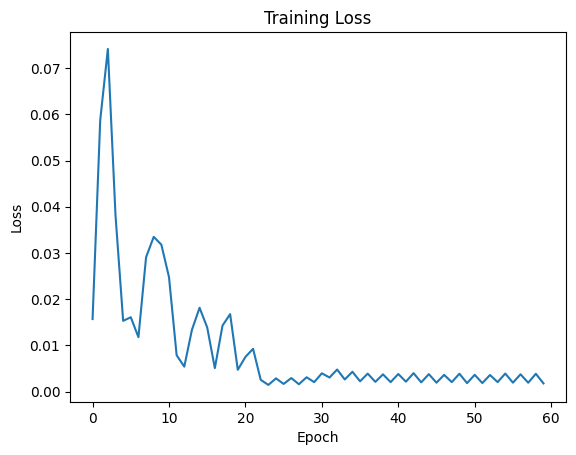

In [37]:
## 에폭~Loss 그래프 그리기
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 추론

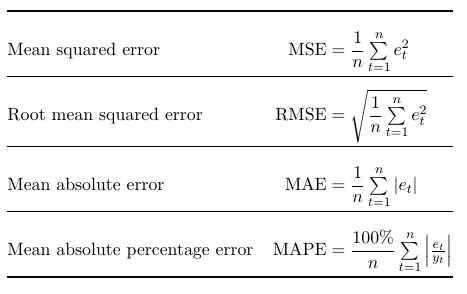

### 전체데이터(학습+테스트) 적용

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 전체 데이터 로더
all_dataset = TensorDataset(X_aapl_tensor, y_aapl_tensor)
all_loader = torch.utils.data.DataLoader(all_dataset,
                                                                                    batch_size = 64,
                                                                                     shuffle = False)

# LSTM 모델 평가 모드로 전환
trained_model.eval()

all_preds_all = []
all_labels_all = []

# 그레디언트 비활성화
with torch.no_grad():
    for X_batch, y_batch in all_loader:  # test_loader를 사용하여 배치 단위로 처리
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 모델 예측 (LSTM 출력)
        y_pred = trained_model(X_batch)

        # 예측 결과와 실제 값 저장
        all_preds_all.append(y_pred.cpu().numpy())     # 예측 결과 저장
        all_labels_all.append(y_batch.cpu().numpy())  # 실제 값 저장

# 예측 값과 실제 값 결합
all_preds_all = np.concatenate(all_preds_all, axis=0)
all_labels_all = np.concatenate(all_labels_all, axis=0)

# 스케일링 복원 (0-1 범위로 스케일링된 값을 실제 주가 값으로 되돌림)
all_preds_all = normalizer.inverse_transform(all_preds_all.reshape(-1, prediction_length))
all_labels_all = normalizer.inverse_transform(all_labels_all.reshape(-1, prediction_length))

# 평가 지표 계산
step_preds = all_preds_all[:, 1]  # 첫번째 예측 시점
step_labels = all_labels_all[:, 1] # 첫번째 예측 시점

mse = mean_squared_error(step_labels, step_preds)
mae = mean_absolute_error(step_labels, step_preds)
mape = mean_absolute_percentage_error(y_true = step_labels, y_pred = step_preds)*100 # 위치가 다르면 값이 바뀜..

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')


Mean Squared Error (MSE): 486.6140
Mean Absolute Error (MAE): 17.8886
Mean Absolute Percentage Error (MAPE): 29.6387%


In [39]:
print("Sample predictions:")
print(all_preds_all[0:10])  # 처음 10개 샘플의 예측 값
print("Corresponding actual values:")
print(all_labels_all[0:10])  # 처음 10개 샘플의 실제 값

Sample predictions:
[[40.855366 41.09076  41.426327]
 [41.09253  41.42962  41.618702]
 [41.43149  41.62205  41.652084]
 [41.62395  41.655415 41.27906 ]
 [41.657272 41.28231  41.584824]
 [41.284035 41.588066 42.203396]
 [41.589905 42.206696 42.320656]
 [42.208664 42.323963 42.3551  ]
 [42.32586  42.35837  42.354538]
 [42.360302 42.35782  42.427418]]
Corresponding actual values:
[[25.187689 25.21444  24.331606]
 [25.21444  24.331606 25.70713 ]
 [24.331606 25.70713  26.50749 ]
 [25.70713  26.50749  26.119574]
 [26.50749  26.119574 26.447294]
 [26.119574 26.447294 26.451752]
 [26.447294 26.451752 26.654627]
 [26.451752 26.654627 26.844873]
 [26.654627 26.844873 26.618816]
 [26.844873 26.618816 26.795635]]


In [40]:
all_preds_all_df = pd.DataFrame(all_preds_all)
all_preds_all_df.columns = ['h1_pred', 'h2_pred', 'h3_pred']

all_labels_all_df = pd.DataFrame(all_labels_all)
all_labels_all_df.columns = ['h1_label', 'h2_label', 'h3_label']

all_preds_all_df.index = stock_data.index[-len(all_preds_all):]
all_labels_all_df.index = stock_data.index[-len(all_labels_all):]

all_preds_all_df

,h1_pred,h2_pred,h3_pred
Date,,,
2015-01-28 00:00:00+00:00,40.855366,41.090759,41.426327
2015-01-29 00:00:00+00:00,41.092529,41.429619,41.618702
2015-01-30 00:00:00+00:00,41.431492,41.622051,41.652084
2015-02-02 00:00:00+00:00,41.623951,41.655415,41.279060
2015-02-03 00:00:00+00:00,41.657272,41.282310,41.584824
...,...,...,...
2023-12-22 00:00:00+00:00,134.516891,134.492188,134.248322
2023-12-26 00:00:00+00:00,134.478851,134.239243,134.428650
2023-12-27 00:00:00+00:00,134.225662,134.419464,134.070557


(MSE): 486.6140
(MAE): 17.8886
(MAPE): 29.6387%


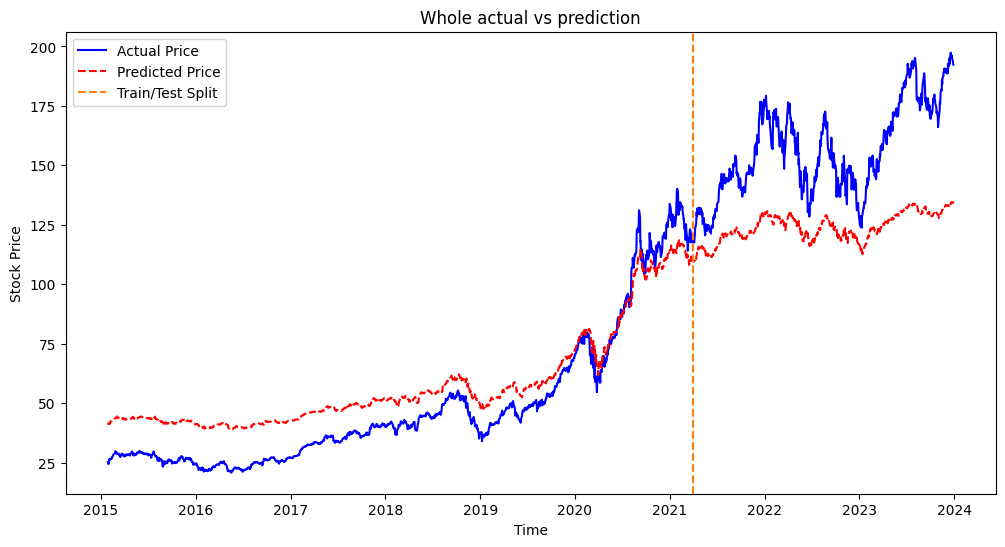

In [41]:
## 시각화 함수 정의
def plot_predictions(all_labels, all_preds, title = None):
    plt.figure(figsize=(12, 6))

    # 실제 주가 데이터 시각화
    plt.plot(all_labels, label='Actual Price', color='blue')

    # 예측된 주가 데이터 시각화
    plt.plot(all_preds, label='Predicted Price', color='red', linestyle='dashed')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    # plt.show()

# 평가 결과 출력
print(f'(MSE): {mse:.4f}')
print(f'(MAE): {mae:.4f}')
print(f'(MAPE): {mape:.4f}%')

# 시각화 함수 호출 (실제 주가와 예측 주가 시각화)
plot_predictions(all_labels_all_df['h1_label'], all_preds_all_df['h1_pred'], title = "Whole actual vs prediction" )
plt.axvline(x = stock_data.index[train_size], c = 'C1',  linestyle = '--',  label = 'Train/Test Split')
plt.legend()

### 테스트 데이터에 적용


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# LSTM 모델 평가 모드로 전환
trained_model.eval()

all_preds_te = []
all_labels_te = []

# 그레디언트 비활성화
with torch.no_grad():
    for X_batch, y_batch in test_loader:  # test_loader를 사용하여 배치 단위로 처리
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 모델 예측 (LSTM 출력)
        y_pred = trained_model(X_batch)

        # 예측 결과와 실제 값 저장
        all_preds_te.append(y_pred.cpu().numpy())  # 예측 결과 저장
        all_labels_te.append(y_batch.cpu().numpy())  # 실제 값 저장

# 예측 값과 실제 값 결합
all_preds_te = np.concatenate(all_preds_te, axis=0)
all_labels_te = np.concatenate(all_labels_te, axis=0)

# 스케일링 복원 (0-1 범위로 스케일링된 값을 실제 주가 값으로 되돌림)
all_preds_te = normalizer.inverse_transform(all_preds_te.reshape(-1, prediction_length))
all_labels_te = normalizer.inverse_transform(all_labels_te.reshape(-1, prediction_length))

# 평가 지표 계산
step_preds = all_preds_te[:, 0]  # 첫번째 예측 시점
step_labels = all_labels_te[:, 0] # 첫번째 예측 시점

mse = mean_squared_error(step_labels, step_preds)
mae = mean_absolute_error(step_labels, step_preds)
mape = mean_absolute_percentage_error(y_true = step_labels, y_pred = step_preds)*100 # 위치가 다르면 값이 바뀜..

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

Mean Squared Error (MSE): 1260.8146
Mean Absolute Error (MAE): 32.9075
Mean Absolute Percentage Error (MAPE): 20.2272%


In [43]:
all_preds_te_df = pd.DataFrame(all_preds_te)
all_preds_te_df.columns = ['h1_pred', 'h2_pred', 'h3_pred']

all_labels_te_df = pd.DataFrame(all_labels_te)
all_labels_te_df.columns = ['h1_label', 'h2_label', 'h3_label']

all_preds_te_df.index = stock_data.index[-len(all_preds_te):]
all_labels_te_df.index = stock_data.index[-len(all_labels_te):]

all_preds_te_df

,h1_pred,h2_pred,h3_pred
Date,,,
2021-04-27 00:00:00+00:00,116.084946,115.591919,115.692299
2021-04-28 00:00:00+00:00,115.573372,115.678780,115.187180
2021-04-29 00:00:00+00:00,115.658623,115.172050,115.902885
2021-04-30 00:00:00+00:00,115.150436,115.887520,116.102867
2021-05-03 00:00:00+00:00,115.865227,116.086975,116.057961
...,...,...,...
2023-12-22 00:00:00+00:00,134.516891,134.492188,134.248322
2023-12-26 00:00:00+00:00,134.478867,134.239258,134.428635
2023-12-27 00:00:00+00:00,134.225662,134.419479,134.070557


(120.0, 180.0)

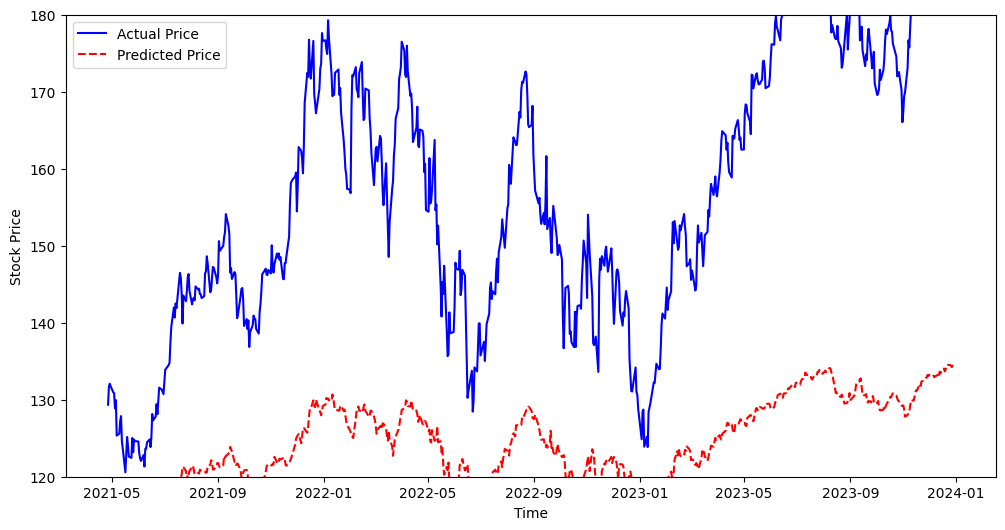

In [44]:
## 줌 인
plot_predictions(all_labels_te_df['h1_label'], all_preds_te_df['h1_pred'])
plt.ylim(120, 180)


## 시점별 예측 결과

Text(0.5, 1.0, 'Stock Price Difference of h1')

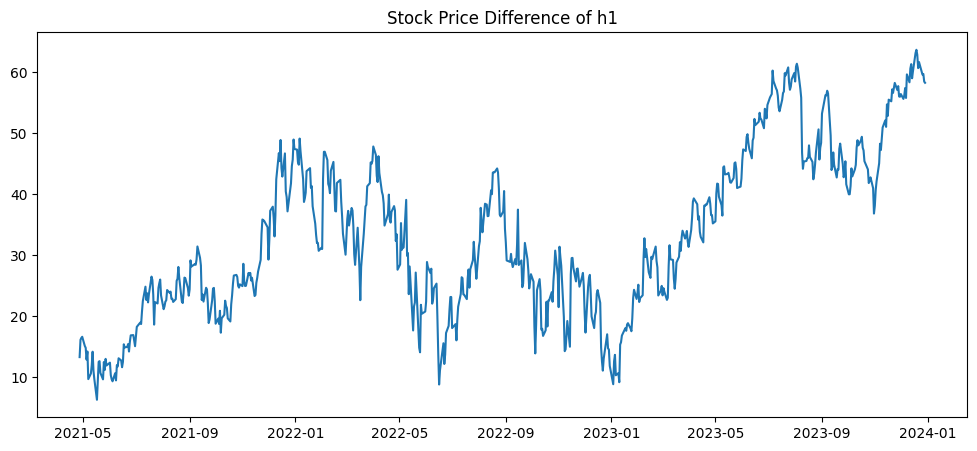

In [45]:
## 예측값 - 실제 값 그래프
stock_diff = all_labels_te_df['h1_label'] - all_preds_te_df['h1_pred']
plt.figure(figsize = (12, 5))
plt.plot(abs(stock_diff))
plt.title('Stock Price Difference of h1')

In [46]:
## 특정 시점에서 2주 입력 데이터와 3일 예측 데이터 시각화 (시간 정보 포함)
def plot_window_predictions(start_idx, all_labels, all_preds, time_series, window_size = 14, prediction_length = 3):
    plt.figure(figsize=(12, 6))

    # 입력 구간 2주 (14일 데이터)
    input_window = range(start_idx, start_idx + window_size)

    # 실제 주가 3일 예측 구간
    actual_window = range(start_idx + window_size, start_idx + window_size + prediction_length)

    # 시간 정보 매핑
    input_times = time_series[start_idx:start_idx + window_size]
    actual_times = time_series[start_idx + window_size:start_idx + window_size + prediction_length]

    # 입력 2주 구간의 실제 주가 시각화 (입력 부분)
    plt.plot(input_times, all_labels[start_idx:start_idx + window_size], label='2 weeks input (actual)', color='blue')

    # 실제 3일간의 주가 시각화
    plt.plot(actual_times, all_labels[start_idx + window_size:start_idx + window_size + prediction_length], label='3 days actual', color='green')

    # 예측된 3일간의 주가 시각화
    plt.plot(actual_times, all_preds[start_idx + window_size:start_idx + window_size + prediction_length], label='3 days predicted', color='red', linestyle='dashed')

    # 차트 설정
    plt.title('2 weeks input and 3 days prediction')
    plt.xlabel('time')
    plt.ylabel('stock price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


original_times = stock_data.index

all_preds = []
all_labels = []
sequence_indices = []  # 시퀀스 인덱스를 저장할 리스트
all_times = []                    # 시간 정보 저장

trained_model.eval() # 평가 모드로 전환
with torch.no_grad(): # 그레디언트 비활성화
    for i, (X_batch, y_batch) in enumerate(test_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 모델 예측
        y_pred = trained_model(X_batch)

        # 예측 값과 실제 값 저장
        all_preds.append(y_pred.cpu().numpy().reshape(-1, prediction_length))
        all_labels.append(y_batch.cpu().numpy().reshape(-1, prediction_length))

        # 시퀀스의 인덱스를 저장 (배치별 시퀀스 시작 인덱스)
        for j in range(X_batch.size(0)):
            sequence_indices.append(i * X_batch.size(0) + j)

        # 시간 정보를 저장 (날짜 또는 타임스텝 정보에 맞게 수정)
        all_times.extend(original_times[i * X_batch.size(0):(i + 1) * X_batch.size(0)])

# 예측 값과 실제 값 결합
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# 스케일링 복원
all_preds = normalizer.inverse_transform(all_preds)
all_labels = normalizer.inverse_transform(all_labels)

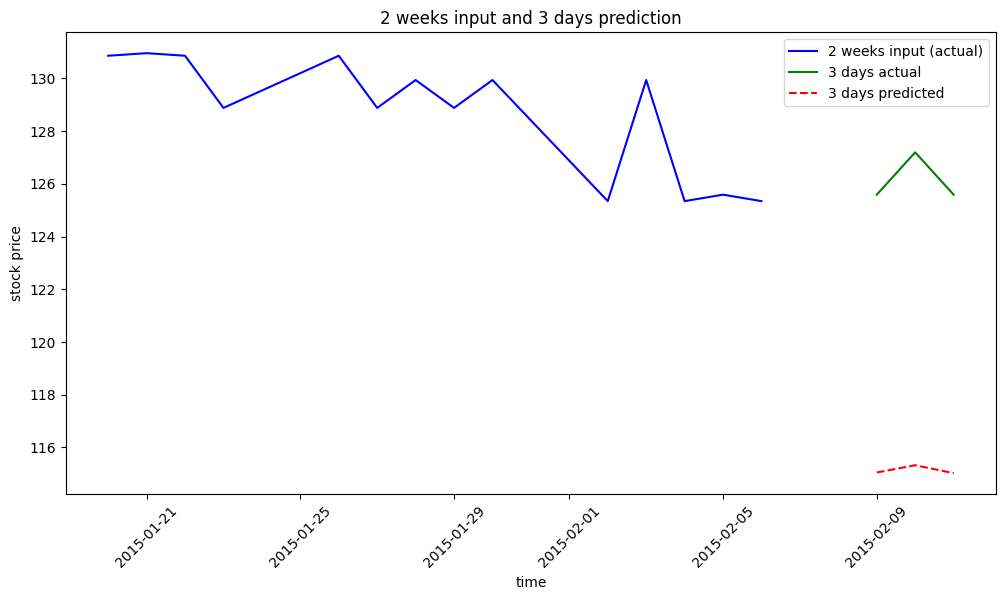

In [47]:
## 특정 인덱스에서 예측 및 실제 데이터 시각화
start_idx = sequence_indices[11]  # 번째 시퀀스의 시작점
plot_window_predictions(start_idx,
                                                      all_labels.flatten(),
                                                      all_preds.flatten(),
                                                      all_times,
                                                      window_size = sequence_length ,
                                                      prediction_length = 3)

## 참고


###  파라미터 갯수 , 가중치 출력하기

In [48]:
## 파라미터 개수를 계산하는 함수 정의
def count_parameters(model):
    # 모델의 학습 가능한 파라미터 중, 각각의 파라미터의 요소 개수를 모두 더하기
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    output = sum(params)

    return output

## 모델의 총 학습 가능한 파라미터 수를 계산하여 출력
total_params = count_parameters(trained_model)
print('Total parameters:' , total_params )

Total parameters: 31051


In [49]:
## 모델의 가중치와 편향을 출력하고, 각 레이어별 파라미터 정보를 출력하는 코드
for name, params in trained_model.named_parameters(): # 모델의 모든 파라미터를 이름과 함께 반환..

    if params.requires_grad:  # 파라미터가 학습 가능한 경우 (requires_grad=True)
        # 레이어 이름, 파라미터의 크기(모양), 파라미터 값 일부를 출력
        print(f'Layer: {name} \n | Size: {params.size()} \n | Values : {params[:2]}\n')


Layer: lstm.weight_ih_l0 
 | Size: torch.Size([200, 1]) 
 | Values : tensor([[-0.1954],
        [-0.5088]], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: lstm.weight_hh_l0 
 | Size: torch.Size([200, 50]) 
 | Values : tensor([[ 0.0311, -0.0252,  0.0451,  0.2000, -0.1279, -0.0212,  0.0803, -0.0109,
         -0.0169,  0.2810, -0.0854,  0.1550,  0.0190, -0.2967,  0.1130, -0.2257,
          0.1950, -0.1244,  0.0302, -0.0468, -0.0856, -0.1069,  0.1357,  0.1726,
          0.1691, -0.0928, -0.0279,  0.0406,  0.0337, -0.0318,  0.0670,  0.0527,
          0.0620,  0.0380,  0.2566, -0.1424, -0.0103, -0.0779, -0.2880,  0.0723,
          0.1375, -0.2430, -0.0746, -0.1212,  0.0466,  0.3666,  0.0858, -0.3062,
          0.2388, -0.0411],
        [ 0.3225, -0.3265,  0.0536, -0.2519, -0.1466, -0.1147, -0.0432,  0.3299,
          0.2857,  0.1783,  0.1689, -0.2064, -0.4224,  0.1902,  0.1638,  0.3155,
         -0.3565, -0.0168,  0.2079,  0.1764, -0.1430,  0.1947,  0.1127, -0.0417,
          0.1592, -0.

## 하이퍼파라미터 최적화

#### 랜덤서치

- 랜덤 서치1
  - GridSearchCV보다 효율적
  - 더 넓은 파라미터 공간을 탐색 할 수 있어서, 최적값을 찾을 확률이 다소 더 높음..

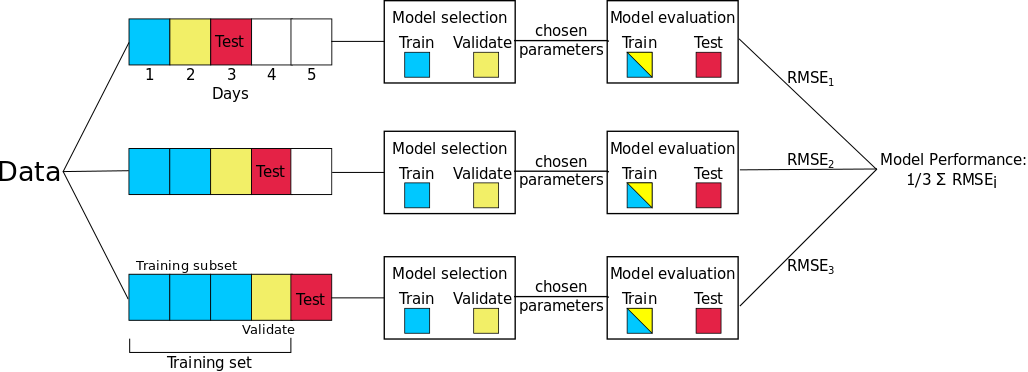

In [50]:
## 오래 걸림...
from sklearn.metrics import mean_squared_error


## 랜덤 하이퍼파라미터 생성 함수
def get_random_hyperparameters():
    return {
        'hidden_size': random.choice([16, 32, 64, 128]),
        'dropout_prob': random.choice([0.0, 0.2, 0.5]),
        'learning_rate': random.choice([0.001, 0.0005, 0.0001]),
        'epochs': random.choice([50, 100, 150]),
        'batch_size': random.choice([16, 32, 64])
    }



## 모델 평가 함수
def evaluate_model(model, X_test, y_test, normalizer=None):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 이동
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # 모델 예측
        y_pred = model(X_test)

        # CPU로 이동하고 NumPy 배열로 변환
        y_pred_np = y_pred.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        # 원래 단위로 역변환
        if normalizer is not None:
            y_pred_np = normalizer.inverse_transform(y_pred_np.reshape(-1, y_pred_np.shape[-1]))
            y_test_np = normalizer.inverse_transform(y_test_np.reshape(-1, y_test_np.shape[-1]))

        # MSE 계산
        mse = mean_squared_error(y_test_np.reshape(-1), y_pred_np.reshape(-1))
    return mse

# 랜덤 서치 반복 횟수 설정
n_iter = 20
best_mse = float('inf')
best_params = {}
best_model = None

# 입력 및 출력 크기 설정
input_size = 1   # 주가 하나의 값
output_size = 1  # 각 타임스텝에서 예측할 주가 값 1개
num_layers = 2  # 고정값


for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()
    print("Current hyperparameters:")
    print(params)

    # 모델 초기화
    model = StockLSTM(input_size=input_size,
                                              hidden_size=params['hidden_size'],
                                              output_size=output_size,
                                              num_layers=num_layers,
                                              dropout_prob=params['dropout_prob']).to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                                                          lr = params['learning_rate'])

    # 모델학습
    loss_history, trained_model = train_model(model, train_loader, criterion, optimizer, params['epochs'])

    # 모델 평가
    mse = evaluate_model(trained_model, X_aapl_test, y_aapl_test)
    print(f"MSE: {mse:.4f}\n")

    # 최고 성능 모델 저장
    if mse < best_mse:
        best_mse = mse
        best_params = params
        best_model = trained_model


Current hyperparameters:
{'hidden_size': 16, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32}
Epoch [1/100], Loss: 0.0522
Epoch [2/100], Loss: 0.0358
Epoch [3/100], Loss: 0.0344
Epoch [4/100], Loss: 0.0317
Epoch [5/100], Loss: 0.0308
Epoch [6/100], Loss: 0.0295
Epoch [7/100], Loss: 0.0274
Epoch [8/100], Loss: 0.0247
Epoch [9/100], Loss: 0.0206
Epoch [10/100], Loss: 0.0143
Epoch [11/100], Loss: 0.0059
Epoch [12/100], Loss: 0.0022
Epoch [13/100], Loss: 0.0032
Epoch [14/100], Loss: 0.0060
Epoch [15/100], Loss: 0.0018
Epoch [16/100], Loss: 0.0020
Epoch [17/100], Loss: 0.0034
Epoch [18/100], Loss: 0.0012
Epoch [19/100], Loss: 0.0010
Epoch [20/100], Loss: 0.0017
Epoch [21/100], Loss: 0.0011
Epoch [22/100], Loss: 0.0009
Epoch [23/100], Loss: 0.0012
Epoch [24/100], Loss: 0.0009
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0009
Epoch [27/100], Loss: 0.0007
Epoch [28/100], Loss: 0.0009
Epoch [29/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0007
Epoch [31/100], 

In [ ]:
## 최적 하이퍼파라미터 출력
print("Best MSE:", best_mse)
print("Best Hyperparameters:", best_params)
print("Best model:", best_model)

Best MSE: 0.0013009264
Best Hyperparameters: {'hidden_size': 128, 'dropout_prob': 0.2, 'learning_rate': 0.0005, 'epochs': 50, 'batch_size': 32}
Best model: StockLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


### 최적화 모델의 결과 확인

In [ ]:
## 모델 Inference (모델 평가)
best_model.eval()  # 평가 모드로 전환

## 그레디언트 계산 비활성화 후 계산만 수행
with torch.no_grad():
    # 데이터를 device에 전달
    X_test_tensor = X_aapl_test.to(device)
    y_test_tensor = y_aapl_test.to(device)  # 이미 텐서라면 변환 필요 없음

    # 모델 예측
    y_pred = best_model(X_test_tensor)

    # CPU로 이동하고 NumPy 배열로 변환
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # 스케일링 복원 (만약 데이터가 스케일링되었다면)
    # normalizer가 있다면 inverse_transform 사용
    if normalizer is not None:
        y_pred_np = normalizer.inverse_transform(y_pred_np.reshape(-1, y_pred_np.shape[-1]))
        y_test_np = normalizer.inverse_transform(y_test_np.reshape(-1, y_test_np.shape[-1]))

    # 평가 지표 계산
    # from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

    mse = mean_squared_error(y_test_np.reshape(-1), y_pred_np.reshape(-1))
    mae = mean_absolute_error(y_test_np.reshape(-1), y_pred_np.reshape(-1))
    mape = mean_absolute_percentage_error(y_test_np.reshape(-1), y_pred_np.reshape(-1)) * 100

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')


Mean Squared Error (MSE): 40.5916
Mean Absolute Error (MAE): 5.0933
Mean Absolute Percentage Error (MAPE): 3.3050%


In [ ]:
y_test_np.reshape(-1)

array([129.35315, 131.68648, 132.07861, ..., 192.32022, 192.41985,
       192.84822], dtype=float32)

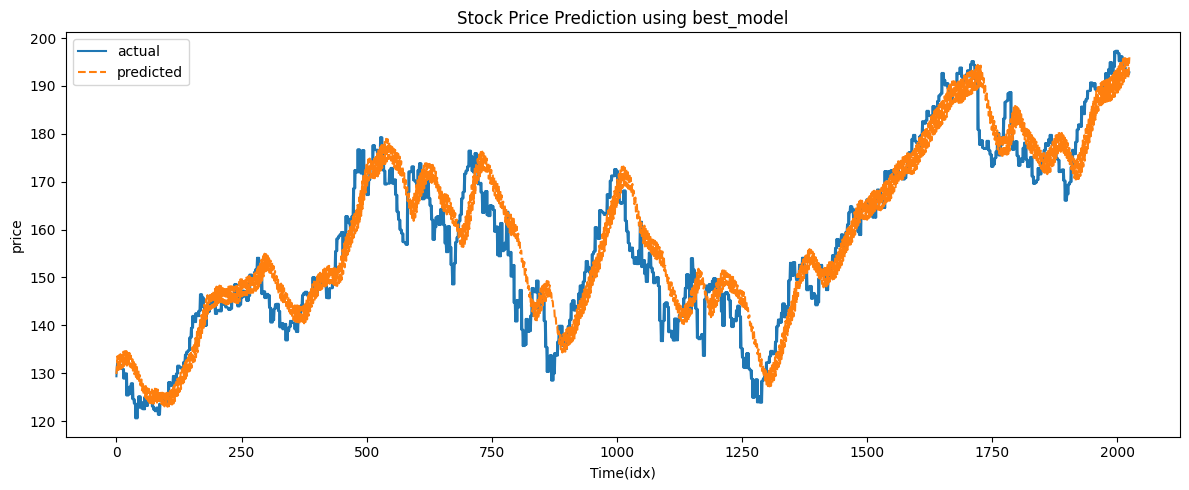

In [ ]:
## 예측값 ~ 실제 값
x = np.arange(len(y_test_np.reshape(-1)))

plt.figure(figsize=(12, 5))
plt.plot(x, y_test_np.reshape(-1), label = 'actual', color = 'C0')
plt.plot(x, y_pred_np.reshape(-1), label = 'predicted', color = 'C1', linestyle = '--' )
plt.title("Stock Price Prediction using best_model")
plt.xlabel('Time(idx)')
plt.ylabel('price')
plt.legend()
plt.tight_layout()
plt.show()

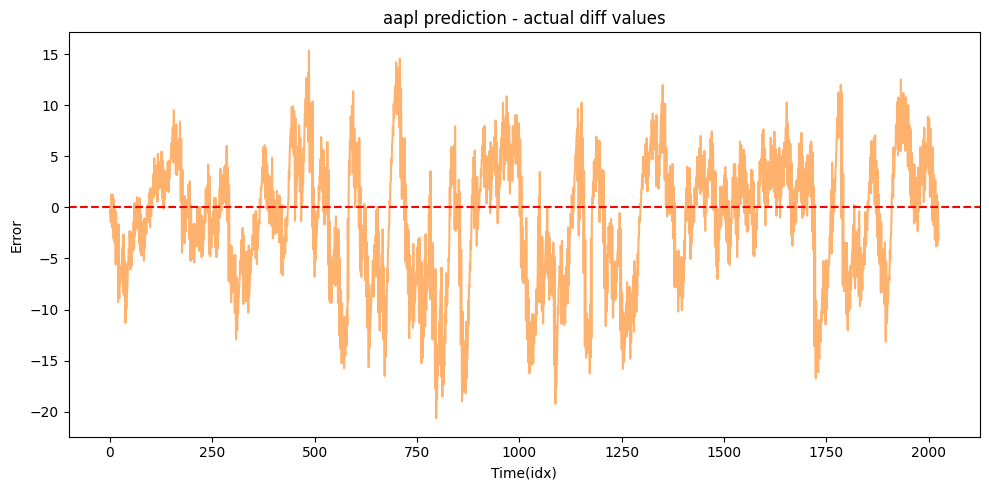

In [ ]:
## 예측 오차 그림
error = y_test_np.reshape(-1) -  y_pred_np.reshape(-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(error)), error, color = 'C1', alpha = 0.6)
plt.title('aapl prediction - actual diff values')
plt.xlabel('Time(idx)')
plt.ylabel('Error')
plt.axhline(y = 0, color = 'r', linestyle='--')
plt.tight_layout()
plt.show()

- 시계열 데이터는 예측하기 어렵다...
  - 내재적 요소
  - 외부 요인..
  
- 하지만, 다음 경우는 잘 맞는 경우도 있음
  - 단기 예측
  - 백테스팅 결과가 아주 좋을 경우 특정 시점 내에
  - 예측에 필요한 변수가 있을 경우


In [ ]:
# EOS